# Understanding Gradient Boosting Models
## ICE_plots for Regression Models

To follow along directly:
1. Clone or download repo at https://github.com/numeristical/resources
2. Navigate to Folder `Understand_GB_Models`
3. Find this notebook `ICE_plot_MLI_Ames.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score
import xgboost as xgb
import ml_insights as mli

#!pip install ml_insights if not installed

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

mli.__version__

'1.0.3'

## Global understanding with ICE Plots
- ### Which variables are most important to the model?
- ### What is the nature of the relationships between the features and the target?
- ### How "interactive" are the features?
    - #### (i.e.) Does the relationship of a feature to the target depend on the values of other features? To what extent?
    

## Ames Housing Data

We'll use the Ames housing data.  In the previous series ("Building a Model") we built several models on this data set.  Here, we will start by rebuilding our final model and analyzing it.

In [2]:
# Load in data, remove outliers, fill some NA with 0, add engineered feature
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)

df_house['BsmtFinSFtotal'] = df_house['BsmtFin SF 1']+df_house['BsmtFin SF 2']
df_house.BsmtFinSFtotal.fillna(0, inplace=True)

In [3]:
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [4]:
# Including the engineered feature
feat = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'BsmtFinSFtotal']



In [5]:
X = df_house.drop(['SalePrice'],axis=1) # everything except Sale Price
y = df_house.SalePrice 

In [6]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [7]:
# Expanded feature set with engineered feature
X_train = X_train_full.loc[:, feat]
X_test = X_test_full.loc[:, feat]

In [8]:
X_test.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Garage Area', 'Fireplaces', 'BsmtFinSFtotal'],
      dtype='object')

## Training a Model
We will take the best model we found from the Series "Building Gradient Boosting Models". 

In [9]:
best = {'colsample_bynode': 0.30000000000000004,
 'max_depth': 8,
 'reg_lambda': 1.4000000000000001,
 'subsample': 0.30000000000000004}
best

{'colsample_bynode': 0.30000000000000004,
 'max_depth': 8,
 'reg_lambda': 1.4000000000000001,
 'subsample': 0.30000000000000004}

In [10]:
xgb_final = xgb.XGBRegressor()
xgb_final.set_params(**best)
xgb_final.set_params(**{'learning_rate':.01,
                        'n_estimators': 10000,
                        'early_stopping_rounds':20},)
xgb_final.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
             verbose=False)
preds_final = xgb_final.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds_final))

18541.026859970538

In [11]:
# Get the mean of your target variable
np.mean(df_house.SalePrice)

180411.5747008547

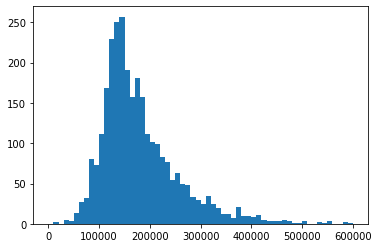

In [12]:
plt.hist(df_house.SalePrice, bins = np.linspace(0,600000,61));

## ICE-Plots
- Individual Conditional Expectation Plots
- Idea: start with a test point, vary one feature across a range of values (while holding all other feature values constant)
- See how the model response changes with the feature value
- Plot several of these lines on the same graph to see how consistent the response is

In [13]:
# choose 5 random data points from the test set
np.random.seed(3)
indices = np.random.choice(np.arange(X_test_full.shape[0]), size=5)
indices

array([362, 152, 249, 131, 256])

In [14]:
test_pts_ice = X_test.iloc[indices,:]
test_pts_ice

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Garage Area,Fireplaces,BsmtFinSFtotal
202,8094,4,5,1915,1950,1962,1,1,4,572.0,1,0.0
966,9157,7,5,2003,2003,2014,2,1,3,486.0,0,0.0
253,12376,7,5,1990,1990,3222,3,0,5,594.0,2,1470.0
2757,13377,6,5,2006,2006,1846,2,0,3,495.0,1,1576.0
2549,8973,5,7,1958,1991,1053,1,1,3,750.0,0,595.0


## ICE-Plots in the ML-Insights package
The ML-insights package has a very feature-rich function to display ICE-plots.  We will demonstrate the basic functionality first, and then demonstrate some more advanced features.

Basic inputs to the `mli.ice_plot` function:

- model: model object you are examining
- base_data: pandas DataFrame containing the points you are "mutating"
- column_names: list of features you wish to explore
- range_pts: dictionary mapping the feature names to the feature-values you wish to plot.  This is easily constructed with the `mli.get_range_dict` function
- pred_fn= Use 'predict_proba' (the default) for classification, 'predict' for regression
 

In [15]:
# First we will get the range_dict with the built-in function
rd = mli.get_range_dict(X_train)
rd.keys(), rd['Year Built']

(dict_keys(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Garage Area', 'Fireplaces', 'BsmtFinSFtotal']),
 array([1872, 1875, 1879, 1880, 1882, 1885, 1890, 1892, 1893, 1895, 1896,
        1898, 1900, 1901, 1902, 1904, 1905, 1906, 1907, 1908, 1910, 1911,
        1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
        1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1934,
        1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1945, 1946, 1947,
        1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
        1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
        1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
        1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]))

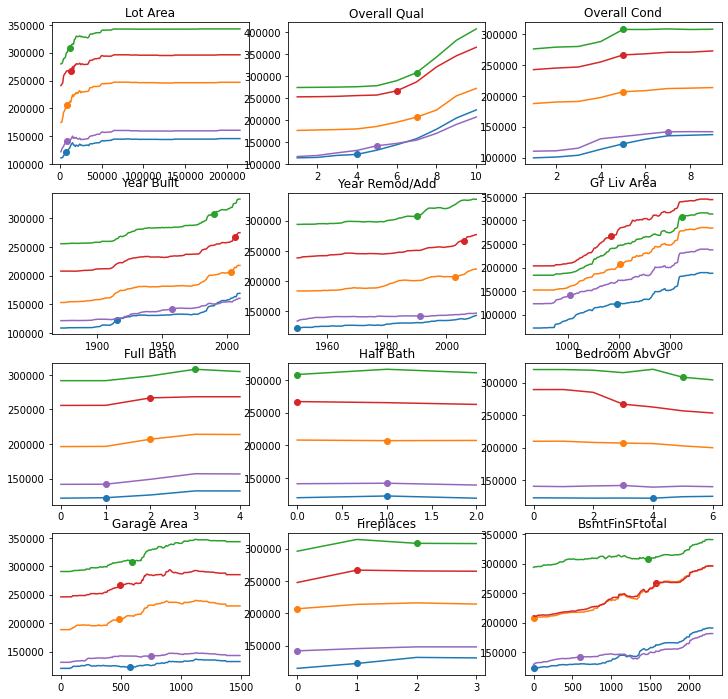

In [16]:
mli.ice_plot(xgb_final, test_pts_ice, test_pts_ice.columns, rd, pred_fn = 'predict')

## Interpreting ICE plots
- Each line represents a particular data point. (5 lines because we gave 5 data points)
- The dot represents the true value of the initial data point.  This is useful to give some context to the plot

Here are things you want to look for:
- When the line is flat, that means the variable is unimportant in that range (for that particular data point)
- When the line is steep, that means the variable has a strong effect on the target in that range.
- If the line is very wiggly, this often betrays some degree of "overfitting" in the model.  Interestingly, this is often *not* reflected in the test set metrics.  However, it is reflective of the "coherence" of the model.  It also may reflect a paucity of training data in that region
- If all the lines show the same basic effect, this suggests that there is little interaction.
- If some lines have very different trajectories, this indicates a high degree of interactivity.

### Adjusting the ranges
The plot for 'Lot Area' is flat after about 75000, but goes out past 250000.  Let's adjust the range to focus on 0 - 75000

In [17]:
rd['Lot Area'] = np.linspace(0,75000,150+1)

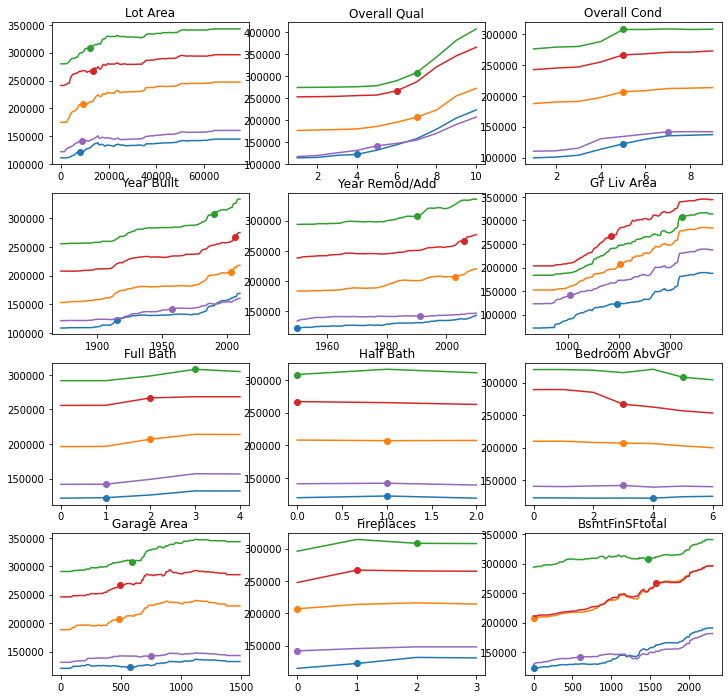

In [18]:
mli.ice_plot(xgb_final, test_pts_ice, test_pts_ice.columns, rd, pred_fn = 'predict')

# Adjusting Plot Size and Layout
You can adjust the size of the individual plots using the following parameters:
- `auto_plot_height` (Default is 4)
- `auto_plot_width` (Default is 3)
- `plots_per_row` (Default is 2)

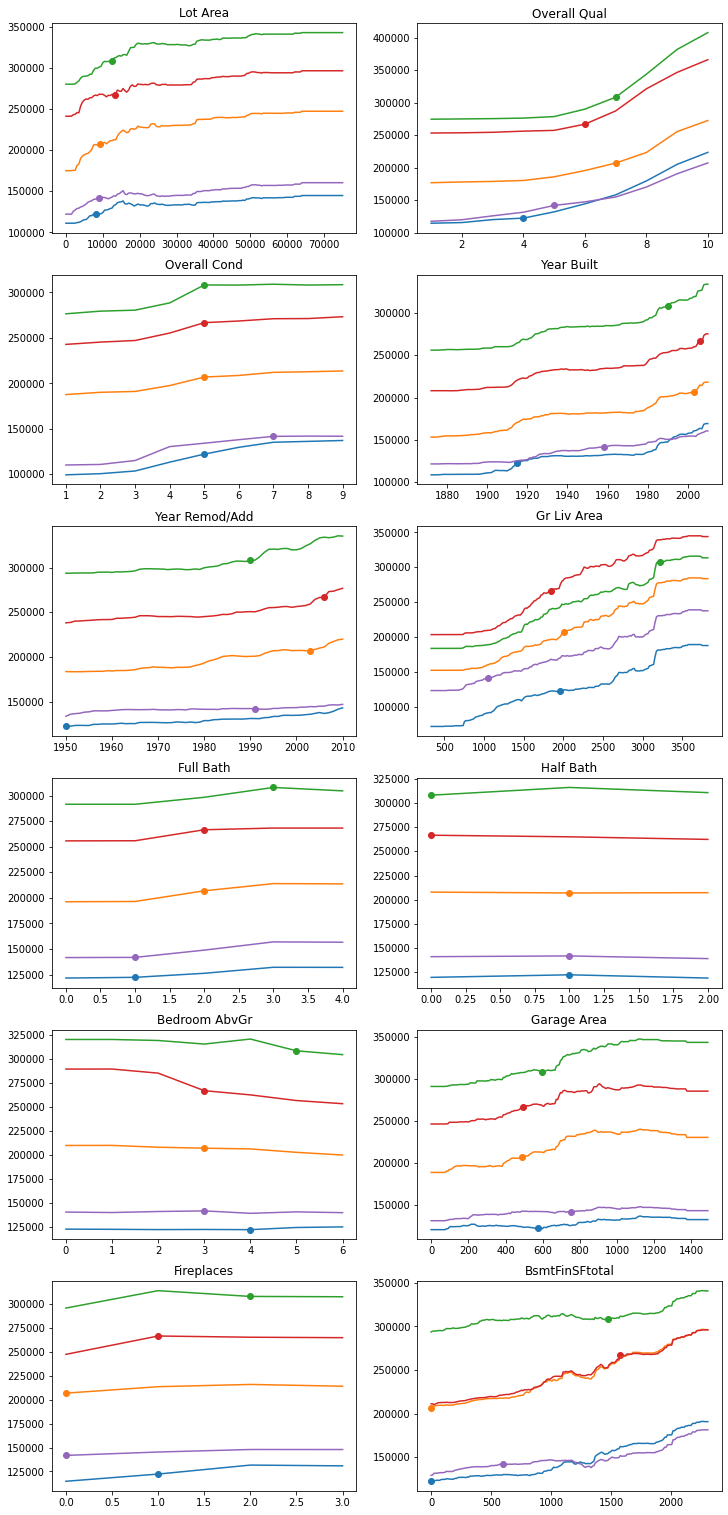

In [19]:
mli.ice_plot(xgb_final, test_pts_ice, test_pts_ice.columns, rd, pred_fn = 'predict',
            auto_plot_height=4.5, auto_plot_width=6, plots_per_row=2)

## Some Caveats in using ICE-Plots
- ICE-plots tell you what the *model* thinks.  To the extent that the model is reflective of the "real world" that generated the data, it may be useful in understanding the real world.  However, it may also be demonstrating places where the model is wrong, has little data, or is displaying artifacts of the way it was trained.  This is where our "human" thinking can be combined with the model to try and understand the world better.

- The response of the model in areas where it has very little training data is generally less trustworthy.

- Tree-based models often suffer from "edge effects" - where a split is made because of one or a few data points in the training set on the extreme end of the range.  The model makes a large "jump" to fit those one or few points.

- ICE-plots may move feature values into ranges that are uncommon or impossible, since we are holding the other feature values constant.  For example, there is unlikely to be a 4-bedroom, 500 square ft house.  So you should not expect the model to do a great job in valuing such a house.



## Showing background data
The `mli.ice_plot` function allows a background histogram intended to show the training data.  You can control this functionality with the following parameters:
- `show_hist`: set to True to display a background histogram (default is False)
- `data_for_hist`: pass the training data here
- `hist_alpha`: controls the transparency / darkness of the plot (1 = darker, 0 = transparent) 
- `hist_color`: set the color of the histogram (default - 'gray')
- `hist_rel_height`: the height of the highest bar in the histogram, as a fraction of the whole plot (default is .7)

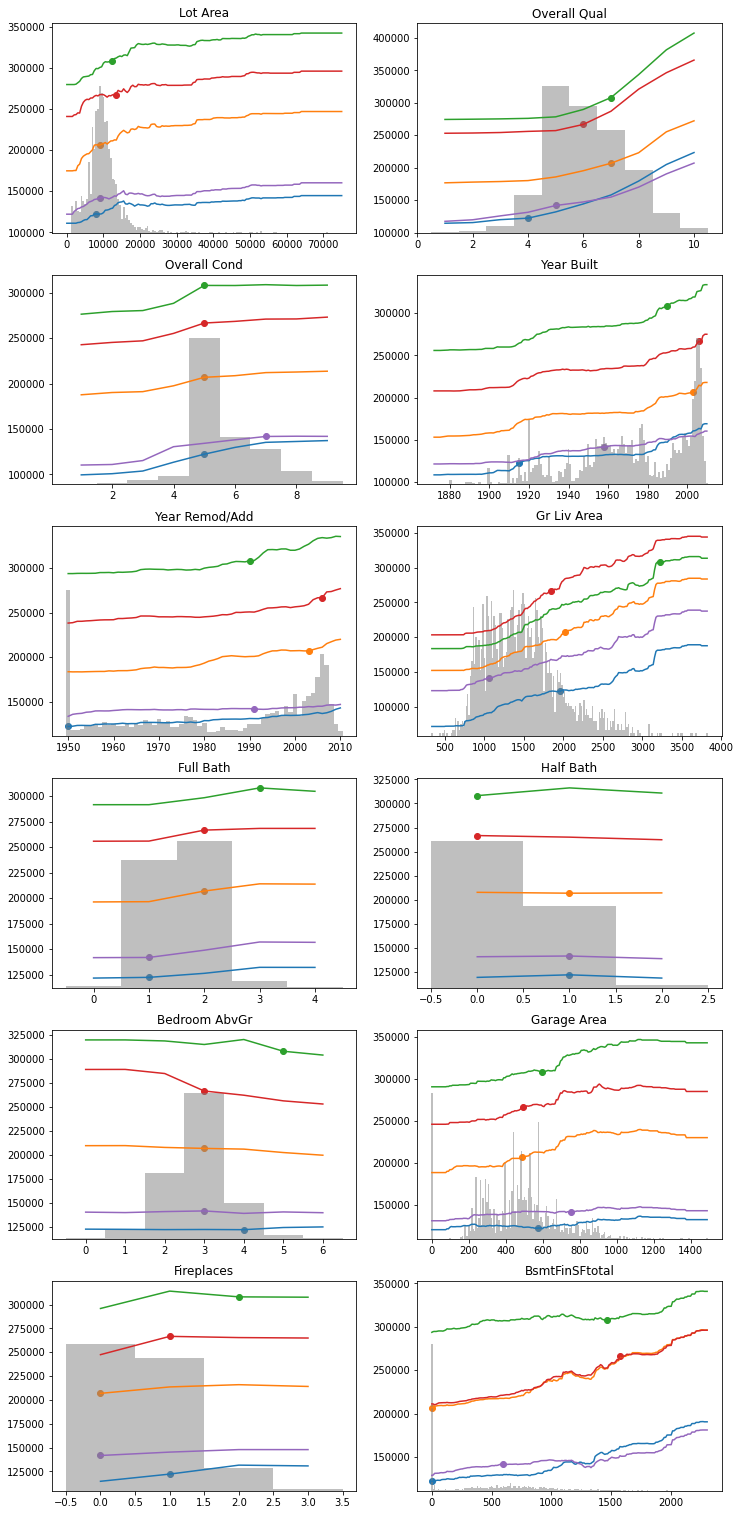

In [20]:
mli.ice_plot(xgb_final, test_pts_ice, test_pts_ice.columns, rd, pred_fn = 'predict',
            auto_plot_height=4.5, auto_plot_width=6, plots_per_row=2,
            show_hist=True, data_for_hist=X_train, hist_alpha=.5)



Using this functionality, we can see that the steep increase for large values of 'Year Built' seem to have a lot of data behind it, whereas this is less true for 'Gr Liv Area'.

We don't see a step change at 1950 for 'Year Remod/Add', but if we did, we would be more likely to trust it based on the large amount of data at exactly that value.

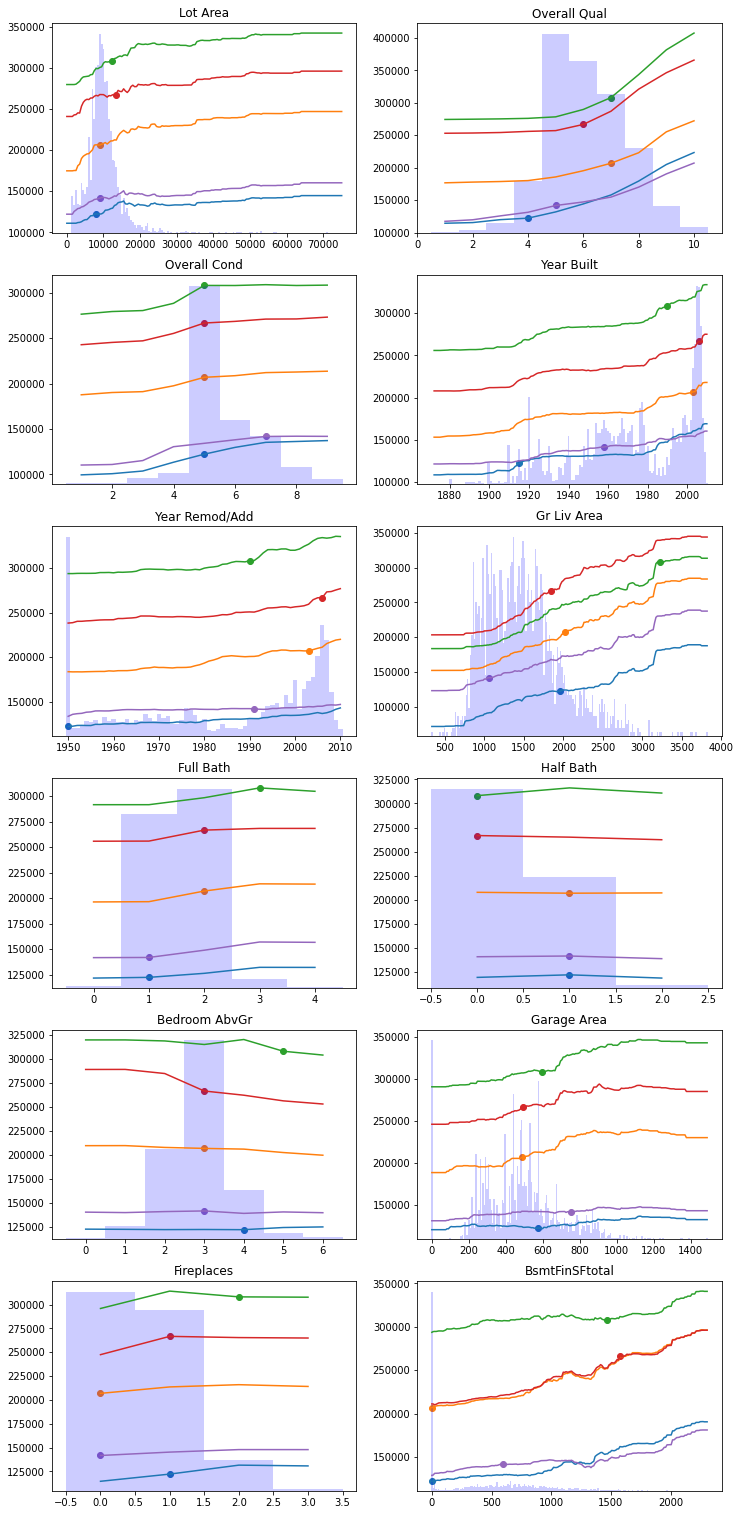

In [21]:
mli.ice_plot(xgb_final, test_pts_ice, test_pts_ice.columns, rd, pred_fn = 'predict',
            auto_plot_height=4.5, auto_plot_width=6, plots_per_row=2,
            show_hist=True, data_for_hist=X_train, hist_alpha=.2,
            hist_color='blue', hist_rel_height=.95)


## Viewing Missing Data Predicted Values
XGBoost, and most modern boosting packages handle missing values natively.  They do this by considering two variants of each split, one where the 'NA' values go left, and another where they go right.

What happens if (as in this data set) there are no missing values.  XGBoost still permits predictions that contain missing values!  But how does it handle them?

The `mli.ice_plot` function allows you to visualize what the prediction will be for a missing value.  While this is most useful if the training data contains missing values, we will use it here to answer the question about XGBoost's treatment of missing values when none exist in the training data.

To show missing values, set `show_nan=True`. The dotted line on the left indicates what the prediction would be if there is a missing value for the feature in question.

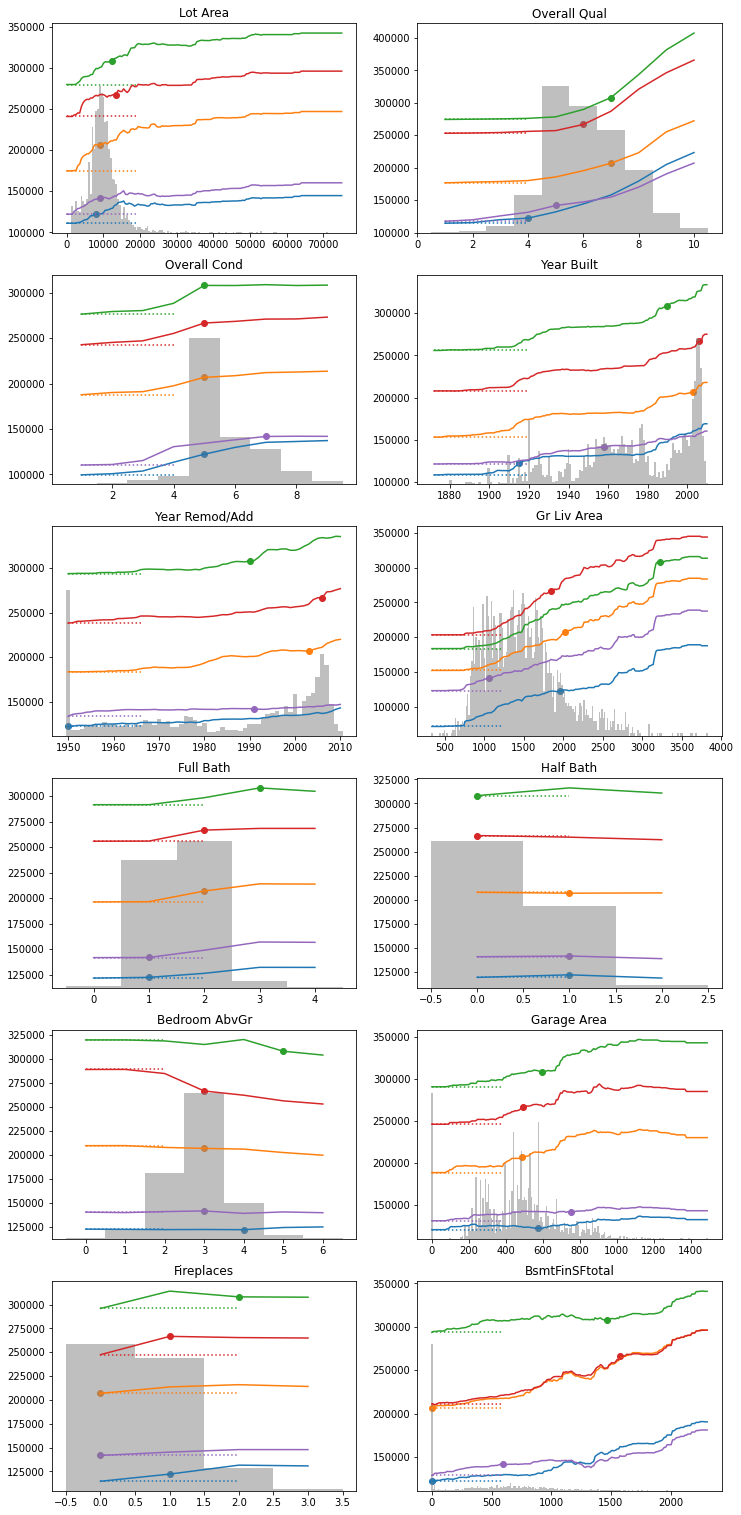

In [22]:
mli.ice_plot(xgb_final, test_pts_ice, test_pts_ice.columns, rd, pred_fn = 'predict',
            auto_plot_height=4.5, auto_plot_width=6, plots_per_row=2,
            show_hist=True, data_for_hist=X_train, hist_alpha=.5,
            show_nan=True)


We can clearly see that XGBoost sends all the missing values to the left (i.e. smaller values) by default.

# Thanks!!